# Modeling callable bonds

In [1]:
import QuantLib as ql 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import datetime as dt

plt.style.use('bmh')

In [2]:
# set evaluation date

eval_date = ql.Date(16, ql.August, 2016)
ql.Settings.instance().evaluationDate = eval_date

In [3]:
# flat yield curve

day_count = ql.ActualActual(ql.ActualActual.Bond)
rate = 0.035

ts = ql.FlatForward(eval_date, 
                    rate,
                    day_count,
                    ql.Compounded,
                    ql.Semiannual)

ts_handle = ql.YieldTermStructureHandle(ts)

In [4]:
# call schedules

callability_schedule = ql.CallabilitySchedule()
call_price = 100
call_date = ql.Date(15, ql.September, 2016)
null_calendar = ql.NullCalendar()

for i in range(24):
    callability_price = ql.BondPrice(call_price,
                                     ql.BondPrice.Clean)
    callability_schedule.append(ql.Callability(callability_price,
                                               ql.Callability.Call,
                                               call_date))
    call_date = null_calendar.advance(call_date, 3, ql.Months)

In [5]:
# bond schedule

issue_date = ql.Date(16, ql.September, 2014)
maturity_date = ql.Date(15, ql.September, 2022)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
tenor = ql.Period(ql.Quarterly)
accrual_convention = ql.Unadjusted

schedule = ql.Schedule(issue_date,
                       maturity_date,
                       tenor,
                       calendar,
                       accrual_convention,
                       accrual_convention,
                       ql.DateGeneration.Backward,
                       False)

In [6]:
# callable bond

settlement_days = 3
face_amount = 100
accrual_daycount = ql.ActualActual(ql.ActualActual.Bond)
coupon = 0.025

bond = ql.CallableFixedRateBond(settlement_days,
                                face_amount,
                                schedule,
                                [coupon],
                                accrual_daycount,
                                ql.Following,
                                face_amount,
                                issue_date,
                                callability_schedule)

In [7]:
# engine

mean_reversion = 0.03
sigma = 0.12
model = ql.HullWhite(ts_handle, mean_reversion, sigma)
engine = ql.TreeCallableFixedRateBondEngine(model, 100)
bond.setPricingEngine(engine)

In [8]:
bond.NPV()

68.82338449304362

In [9]:
bond.cleanPrice()

68.40143847089621

In [10]:
bond.accruedAmount()

0.4415760869565189

In [11]:
bond.dirtyPrice()

68.84301455785273

In [12]:
cash_flows = [(cf.date(), cf.amount()) for cf in bond.cashflows()]

In [13]:
def convert_date(d):
    return dt.date(d.year(), d.month(), d.dayOfMonth())

In [14]:
cash_flows_df = pd.DataFrame(cash_flows, columns=['Date', 'Cashflows'])
cash_flows_df.Date =  cash_flows_df.Date.apply(convert_date)
cash_flows_df.set_index('Date', inplace=True)
cash_flows_df.head()

,Cashflows
Date,
2014-12-15,0.618132
2015-03-16,0.625000
2015-06-15,0.625000
2015-09-15,0.625000
2015-12-15,0.625000


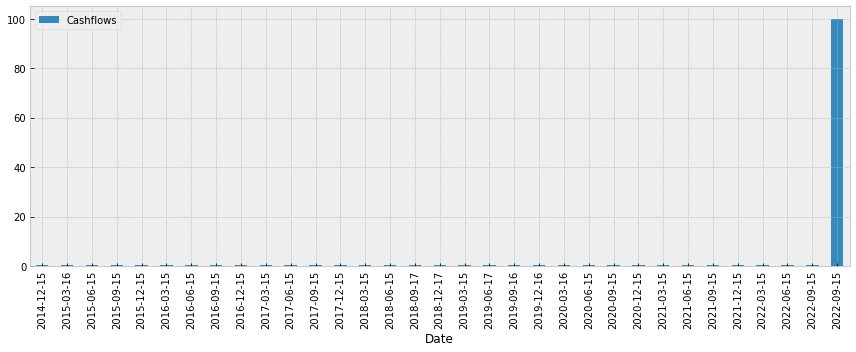

In [15]:
cash_flows_df.plot(kind='bar', figsize=(12,5))
plt.tight_layout()
plt.show()

In [16]:
prices = []

for sigma in np.linspace(0.01, 0.5, 100):
    model = ql.HullWhite(ts_handle, mean_reversion, sigma)
    engine = ql.TreeCallableFixedRateBondEngine(model, 100)
    bond.setPricingEngine(engine)
    prices.append(bond.cleanPrice())

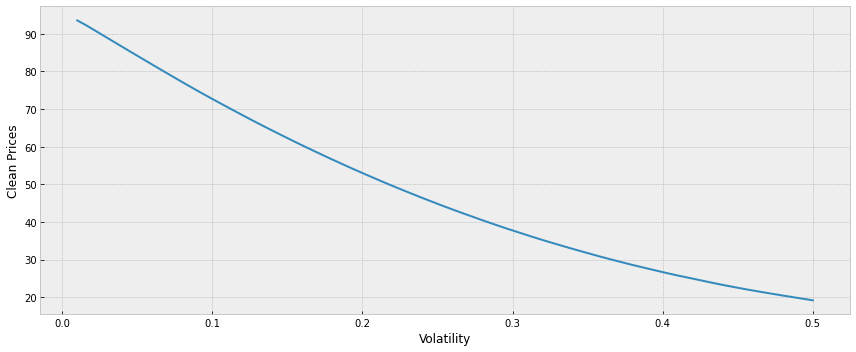

In [17]:
# volatiltiy increase --> higer chance of being call --> call has higher value --> bond price decreases

fig, ax = plt.subplots(figsize=(12,5))

ax.plot(np.linspace(0.01,0.5,100), prices)
ax.set_xlabel('Volatility')
ax.set_ylabel('Clean Prices')

plt.tight_layout()
plt.show()